In [1]:
# 1. 각각의 Client로컬 학습 모델의 Receptive Field를 계산한다.
# 

import os
import sys
import pathlib
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import torch

def load_all_models(path):
    folder_path = path
    file_list = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".pth"):
                file_list.append(pathlib.Path(root) / file)
    # sorting file_list
    file_list.sort()
    # dirnames
    model_state_dict = {}
    for file in file_list:
        print("file_name : ", file)
        # get index from file name ex. "client_0_best_models" > "0", "test 1" > "1"
        if 'global' in file.parent.name:
            model_state_dict[-1] = torch.load(file) 
            print("file.parent.name: ", file.parent.name)
        else:
            index = int(file.parent.name.split('_')[1])
            model_state_dict[index] = torch.load(file)
            print("file.parent.name: ", file.parent.name, "index: ", index)
    return model_state_dict

# model_state_dict = load_all_models("/home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/31265")# 55227")
# model_state_dict = load_all_models("/home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/55227")# ")

# model_state_dict[-1] = torch.load("/home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/59831/global/model_round15_acc83.90_loss0.69.pth")


model_state_dict = {}
model_state_dict[-1] = torch.load("/home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/59831/global/model_round15_acc83.90_loss0.69.pth")
model_state_dict[-2] = torch.load("/home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/17751/global/model_round89_acc82.38_loss0.59.pth")
# model_state_dict[-1] = torch.load("/home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/42705/client_3_best_models/model_round88_acc88.08_loss0.36.pth")
# model_state_dict.update(load_all_models("/home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/55227")) # iid
model_state_dict.update(load_all_models("/home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/56121")) # non-iid24211

file_name :  /home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/56121/client_0_best_models/model_round49_acc79.41_loss0.90.pth
file.parent.name:  client_0_best_models index:  0
file_name :  /home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/56121/client_1_best_models/model_round86_acc90.98_loss0.27.pth
file.parent.name:  client_1_best_models index:  1
file_name :  /home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/56121/client_2_best_models/model_round30_acc94.40_loss0.22.pth
file.parent.name:  client_2_best_models index:  2
file_name :  /home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/56121/client_3_best_models/model_round53_acc90.52_loss0.28.pth
file.parent.name:  client_3_best_models index:  3
file_name :  /home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/56121/client_4_best_models/model_round60_acc95.83_loss0.24.pth
file.parent.name:  client_4_best_models index:  4
file_name :  /home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/56121/client_5_best_models/model_

In [2]:
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.transforms.functional import InterpolationMode
from torch.utils.data import DataLoader
from PIL import Image

import albumentations as A
from albumentations.pytorch import ToTensorV2

import models
import utils
import datasets
import config
utils.set_seed(42)

In [3]:
args = config.init_args(server=True, ipykernel=True)

args.excluded_heads []


In [4]:
args.batch_size = 100
datasetpartition = datasets.PascalVocSegmentationPartition(args)
train_dataset, valid_dataset = datasetpartition.load_partition(-1)
valid_loader = DataLoader(valid_dataset, batch_size=args.batch_size, shuffle=False, num_workers=0 )
test_loader = valid_loader

malicious clients: []
dirichlet
1464 1449


In [5]:
network = models.get_network("segformer", 21, pretrained=True)
network2 = models.get_network("deeplabv3plus", 21, pretrained=True)

Loading pretrained model...


In [6]:
img, lab = next(iter(test_loader))

In [ ]:
import torch
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def compute_erf_gradients(model, input_tensor, layers):
    # Make sure the model is in evaluation mode and gradients can be computed
    model.eval()
    
    # Make the input tensor require gradients
    input_tensor.requires_grad_()
    
    # Forward pass to get the feature maps after residual connections
    feature_maps = []
    hooks = []
    
    # Hook to capture feature maps
    def hook_fn(module, input, output):
        print("hook called")
        feature_maps.append(output)
    
    # Register hooks for the specified layers
    for layer in layers:
        hook = layer.register_forward_hook(hook_fn)
        hooks.append(hook)
    
    # Forward pass
    _ = model(input_tensor)
    
    # Compute gradients for the center location of feature maps
    gradients = []
    for fmap in feature_maps:
        # Only consider the center pixel
        center_pixel = fmap[0, :, fmap.size(2) // 2, fmap.size(3) // 2]
        # Backward pass
        center_pixel.backward(gradient=torch.ones_like(center_pixel), retain_graph=True)
        # Get gradients
        gradients.append(input_tensor.grad.abs().clone())
        # Reset gradients
        input_tensor.grad.zero_()
    
    # Remove hooks
    for hook in hooks:
        hook.remove()
    
    return gradients

# Example usage:
# Navigating through the model architecture and selecting layers
# after the attention and feed-forward blocks (assuming these are the residual connections you are referring to).
# layers = [model.to_fused[0][0], model.to_fused[1][0], model.to_fused[2][0], model.to_fused[3][0]]
# layers = [model.mit.stages[0][1], model.mit.stages[1][1], model.mit.stages[2][1], model.mit.stages[3][1], model.to_segmentation[1]]
# layers = [network.backbone.patch_embed1.proj, network.backbone.patch_embed2.proj, network.backbone.patch_embed3.proj, network.backbone.patch_embed3.proj]
layers = [network.encoder.layer1, network.encoder.layer2, network.encoder.layer2, network.encoder.layer3]

# Generate random input tensor
input_tensor = img #
input_tensor = torch.randn(1, 3, 224, 224)
total_clients = len(model_state_dict.keys())
fig = plt.figure(figsize=(8, total_clients*2))
# Compute ERF gradients
for i, j in enumerate(model_state_dict.keys()):
    network.load_state_dict(model_state_dict[j])
    if j == -2:
        layers = [network2.encoder.layer1, network2.encoder.layer2, network2.encoder.layer2, network2.encoder.layer3]
        erf_gradients = compute_erf_gradients(network2, input_tensor, layers)
    else :
        layers = layers = [network.backbone.patch_embed1.proj, network.backbone.patch_embed2.proj, network.backbone.patch_embed3.proj, network.backbone.patch_embed3.proj]
        erf_gradients = compute_erf_gradients(network, input_tensor, layers)

    # Visualize gradients
    for k, grad in enumerate(erf_gradients):
        # plt.subplot(layers, len(model_state_dict.keys()), 1)
        # plt.subplot(total_clients, len(layers), k + 1 + i*len(layers))
        # pivot x, y
        plt.subplot(len(layers), total_clients, k*len(model_state_dict.keys()) + i + 1)
        if j == -1:
            plt.title(f'stages {k + 1}')
        plt.imshow(grad[0].sum(dim=0).numpy(), cmap='hot')
        plt.axis('off')
plt.tight_layout()
plt.savefig("./figure2_receptive_field.png", dpi=300)
plt.show()



In [ ]:
list(network.backbone.children())

In [11]:
import torch
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def compute_erf_gradients(model, input_tensor, layers):
    # Make sure the model is in evaluation mode and gradients can be computed
    model.eval()
    
    # Make the input tensor require gradients
    input_tensor.requires_grad_()
    
    # Forward pass to get the feature maps after residual connections
    feature_maps = []
    hooks = []
    
    # Hook to capture feature maps
    def hook_fn(module, input, output):
        print("hook called")
        feature_maps.append(output)
    
    # Register hooks for the specified layers
    for layer in layers:
        hook = layer.register_forward_hook(hook_fn)
        hooks.append(hook)
    
    # Forward pass
    _ = model(input_tensor)
    
    # Compute gradients for the center location of feature maps
    gradients = []
    for fmap in feature_maps:
        # Only consider the center pixel
        center_pixel = fmap[0, :, fmap.size(2) // 2, fmap.size(3) // 2]
        # Backward pass
        center_pixel.backward(gradient=torch.ones_like(center_pixel), retain_graph=True)
        # Get gradients
        gradients.append(input_tensor.grad.abs().clone())
        # Reset gradients
        input_tensor.grad.zero_()
    
    # Remove hooks
    for hook in hooks:
        hook.remove()
    
    return gradients

# Example usage:
# Navigating through the model architecture and selecting layers
# after the attention and feed-forward blocks (assuming these are the residual connections you are referring to).
# layers = [model.to_fused[0][0], model.to_fused[1][0], model.to_fused[2][0], model.to_fused[3][0]]
# layers = [model.mit.stages[0][1], model.mit.stages[1][1], model.mit.stages[2][1], model.mit.stages[3][1], model.to_segmentation[1]]
# layers = [network.backbone.patch_embed1.proj, network.backbone.patch_embed2.proj, network.backbone.patch_embed3.proj, network.backbone.patch_embed3.proj]
# Generate random input tensor
input_tensor = img #
network = network
# input_tensor = torch.randn(1, 3, 224, 224)
n_clients = len(model_state_dict.keys())
n_layers = 4
fig_size = 2
fig = plt.figure(figsize=(n_layers*fig_size, n_clients*fig_size))
# Compute ERF gradients
total_erf_grads = {}
for i, j in enumerate(list(model_state_dict.keys())):
    if j == -2:
        network2.load_state_dict(model_state_dict[j])
        layers = [network2.encoder.layer1, network2.encoder.layer2, network2.encoder.layer2, network2.encoder.layer3]
        erf_gradients = compute_erf_gradients(network2, input_tensor, layers)
    else :
        network.load_state_dict(model_state_dict[j])
        layers = [network.backbone.patch_embed1.proj, network.backbone.patch_embed2.proj, network.backbone.patch_embed3.proj, network.backbone.patch_embed3.proj]
        erf_gradients = compute_erf_gradients(network, input_tensor, layers)
        
    total_erf_grads[j] = {}
    for k, grad in enumerate(erf_gradients):
        grad = grad.cpu()
        total_erf_grads[j][k] = grad

import pickle
with open("./total_erf_grads.pkl", "wb") as f:
    pickle.dump(total_erf_grads, f)



hook called
hook called
hook called
hook called
hook called
hook called
hook called
hook called
hook called
hook called
hook called
hook called
hook called
hook called
hook called
hook called
hook called
hook called
hook called
hook called
hook called
hook called
hook called
hook called
hook called
hook called
hook called
hook called
hook called
hook called
hook called
hook called
hook called
hook called
hook called
hook called
hook called
hook called
hook called
hook called
hook called
hook called
hook called
hook called
hook called
hook called
hook called
hook called


<Figure size 800x2400 with 0 Axes>

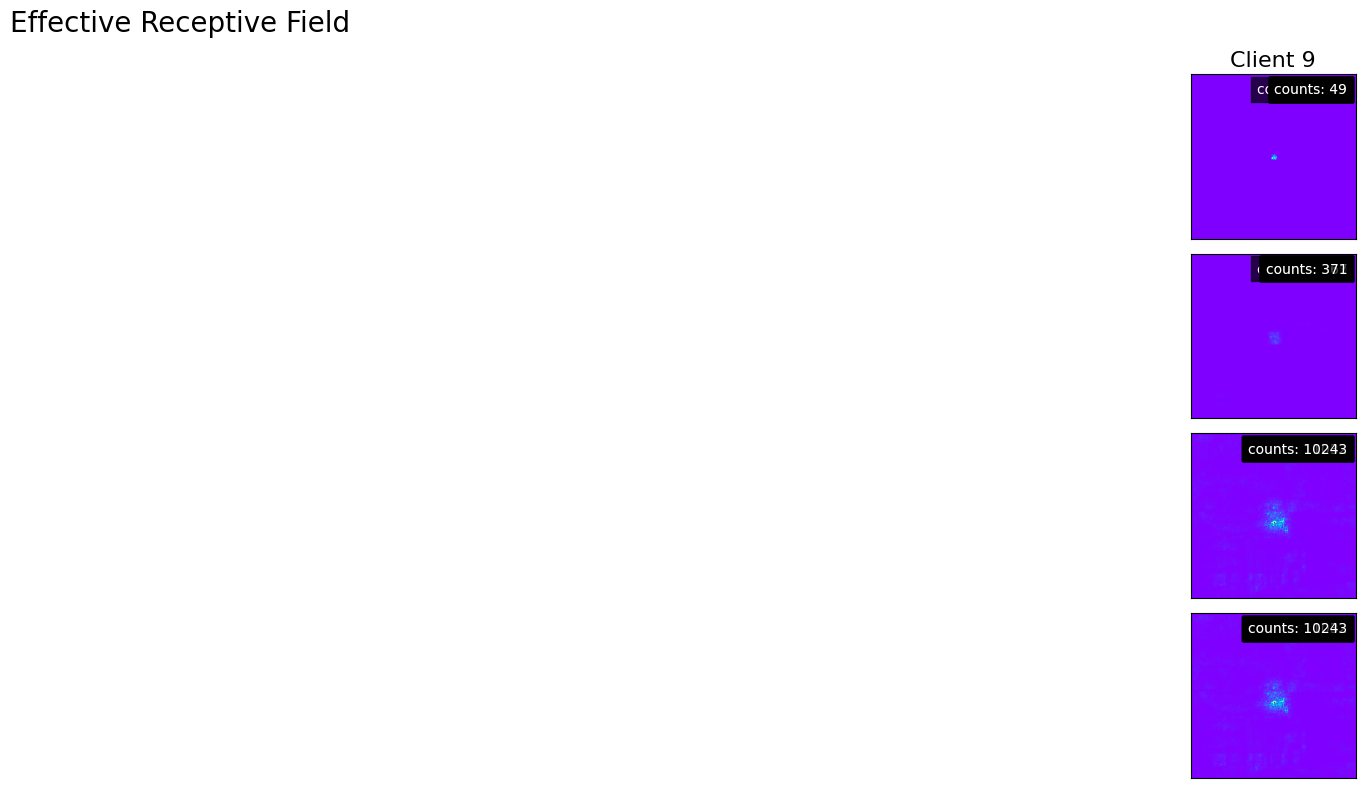

In [13]:

# save total erf grads to pickle
import pickle
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

with open("./total_erf_grads.pkl", "rb") as f:
    total_erf_grads = pickle.load(f)

fig_size = 2
n_clients = len(total_erf_grads.keys())
n_layers = len(total_erf_grads[list(total_erf_grads.keys())[0]])
fig = plt.figure(figsize=(n_clients*fig_size, n_layers*fig_size))
# Visualize gradients

# for i, k in enumerate(sorted(list(total_erf_grads.keys()))):
for k in sorted(list(total_erf_grads.keys())):
    # print("k: ", k)
    for j in range(len(total_erf_grads[k])):
        # print("j: ", j)
        grad = total_erf_grads[k][j][0].sum(dim=0).cpu()
        # print("grad : ", grad)
        # print("grad : ", grad)
        max_grad = grad.max()
        median_grad = grad.median()
        avg_grad = grad.mean()
        min_grad = grad.min()
        # print(f"max_grad: {max_grad}, median_grad: {median_grad}, avg_grad: {avg_grad}, min_grad: {min_grad}")
        # counts = morethan avg_grad
        counts = (grad > 0.01).sum()
        # print(f"counts: {counts}")
        not_zero_pixel_cnt = (grad != 0).sum()
        # print(f"client {k}, stage {j+1}, not zero pixel cnt: ", not_zero_pixel_cnt)
        plt.subplot(n_layers, n_clients, i + j*n_clients + 1)
        plt.imshow(total_erf_grads[k][j][0].sum(dim=0).numpy(), cmap='rainbow')
        # plt.axis('off')
        if i == 0:
            plt.ylabel(f'Stage {j + 1}', fontsize=16)
        if j == 0:
            client_name  = f"Client {k}"
            client_name  = client_name if k != -2 else "FL-DL+-Rn34"
            client_name  = client_name if k != -1 else "FL-Segformer"
            plt.title(client_name, fontsize=16)
        plt.yticks([])
        plt.xticks([])
        # colormap range
        plt.clim(0, 1)
        # text right top with counts
        plt.text(0.95, 0.95, f"counts: {counts}", color='white', fontsize=10, bbox=dict(facecolor='black', alpha=0.7)
                 , verticalalignment='top', horizontalalignment='right', transform=plt.gca().transAxes)
plt.suptitle("Effective Receptive Field", fontsize=20)
plt.tight_layout()
plt.savefig("./figure2_receptive_field.png", dpi=300)
plt.show()
